***Classification of DNA Sequence Using Hybrid CNN-LS***



# Reading Dataset



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
#from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load dataset from github
def load_data(url):
  filepath = os.path.join(url, '?raw=true')
  data = pd.read_csv(filepath)
  return data

url = 'https://github.com/mobilttterbang/DNA_Classification_Project/blob/main/dataset/Complete_DM_DNA_Sequence.csv'

DNA = load_data(url)
DNA.head(20)

,sequence,length,class
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,1010,DMT2
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1010,DMT2
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1013,DMT2
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,1013,DMT2
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1015,DMT2
5,TGTGCACGCACCCTCTCCCTCATCCACCGCTGTCACCTCCTGCTGC...,1017,DMT2
6,TGTGCACGCACCCTCTCCCTCATCCACCGCTGTCACCTCCTGCTGC...,1017,DMT1
7,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1020,DMT2
8,ATTAATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAG...,1042,DMT2
9,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1048,DMT2


In [ ]:
class_distribution = DNA['class'].value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
class
NONDM    989
DMT2     443
DMT1     145
Name: count, dtype: int64


In [ ]:
colors = sns.color_palette("Dark2", len(DNA['class'].unique()))
colors

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)]

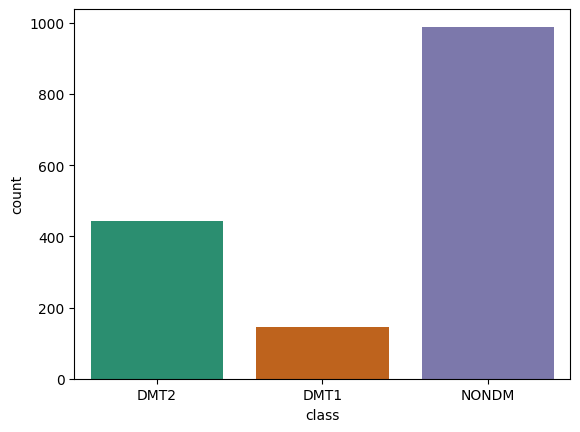

In [ ]:
# shape of the dataset
DNA.shape
sns.countplot(DNA, x='class',palette=colors)
plt.show()

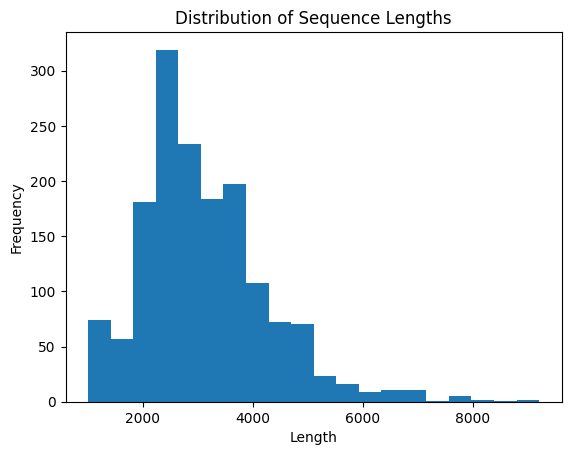

In [ ]:
lengths = [len(seq) for seq in DNA['sequence']]
plt.hist(lengths,bins=20)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

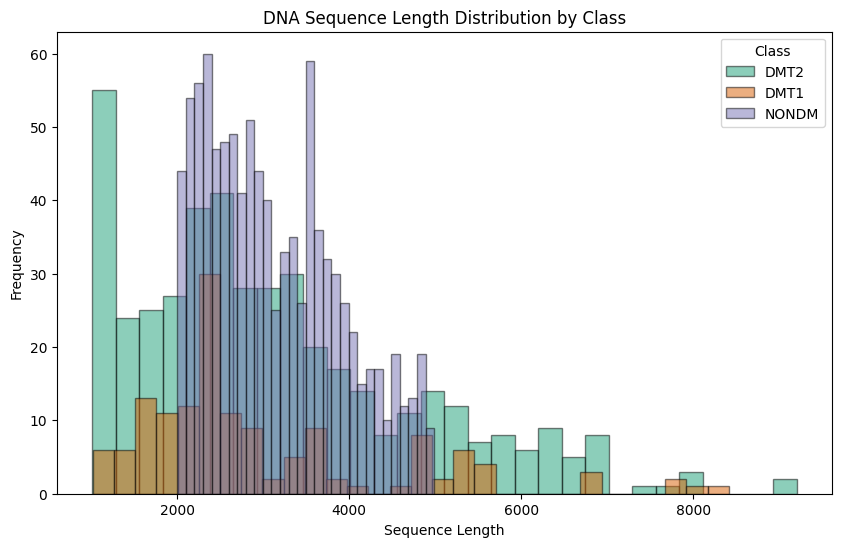

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate sequence lengths and add as a new column
DNA['sequence_length'] = DNA['sequence'].apply(len)

# Plot the distribution of sequence lengths for each class
plt.figure(figsize=(10, 6))

# Loop over each class to plot its length distribution
for i,class_label in enumerate(DNA['class'].unique()):
    # Filter rows by class and plot the length distribution
    class_lengths = DNA[DNA['class'] == class_label]['sequence_length']
    plt.hist(class_lengths, bins=30, alpha=0.5, label=class_label, edgecolor='black',color=colors[i])

# Add titles and labels
plt.title('DNA Sequence Length Distribution by Class')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend(title='Class')
plt.show()

The dataset consists of DNA sequences, where each sequence has a specific length and is assigned to one of multiple classes. Two main challenges are noted:

Varying Sequence Lengths: The DNA sequences are not all the same length, meaning they vary in the number of nucleotides. This inconsistency can complicate the process of building a model since many machine learning models expect input data to be uniform in shape.

Class Imbalance: The dataset is imbalanced, meaning some classes (e.g., different types of diabetes) have significantly more samples than others. This imbalance can lead the model to favor the more common classes, potentially reducing its accuracy on less-represented classes

# Feature Extraction

*   Fixed-Length Representation: K-mers allow for a consistent representation across sequences of varying lengths, which is critical for feeding data into machine learning models.
*   Sequence Composition: Different classes (e.g., disease states) often have distinct k-mer distributions that can act as discriminative features.





In [ ]:
# define k-mers function to split the sequence into group of k-mers words
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

# apply the k-mers function
DNA['k-mers'] = DNA.apply(lambda x: getKmers(x['sequence']), axis=1)
DNA[['sequence','k-mers']].head()

,sequence,k-mers
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,"[aat, ata, taa, aat, att, ttt, ttg, tgt, gtg, ..."
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,"[agt, gtt, ttg, tgg, gga, gag, agt, gtc, tct, ..."
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."


In [ ]:
num_samples = DNA.shape[0]
k_mer_lengths = DNA['k-mers'].apply(len)

unique_k_mer_counts = k_mer_lengths.unique()

print(f"Number of samples: {num_samples}")
print(f"Unique k-mer lengths per sample: {unique_k_mer_counts}")
len(unique_k_mer_counts)

Number of samples: 1577
Unique k-mer lengths per sample: [1008 1011 1013 ... 8414 9030 9203]


1231

Splitting the data into 2 variables features and targets

In [ ]:
# DNA features
DNA_features = list(DNA['k-mers'])
for item in range(len(DNA_features)):
    DNA_features[item] = ' '.join(DNA_features[item]) # to remove "," between k mers and then save it all in same sequence


# DNA targets
DNA_targets = DNA['class'].copy()

In [ ]:
lengths = [len(item) for item in DNA_features]
print(f"Lengths of each k-mer list: {lengths}")
print("________________________________________________")
print("________________________________________________")
print("________________________________________________")

# If you want to get unique lengths
unique_lengths = set(lengths)
print(f"Unique lengths of k-mer lists: {unique_lengths}")

Lengths of each k-mer list: [4031, 4031, 4043, 4043, 4051, 4059, 4059, 4071, 4159, 4183, 4211, 4227, 4231, 4247, 4255, 4263, 4291, 4291, 4303, 4319, 4351, 4351, 4355, 4379, 4399, 4415, 4415, 4431, 4479, 4543, 4543, 4603, 4619, 4655, 4667, 4667, 4687, 4703, 4711, 4727, 4747, 4763, 4763, 4839, 4843, 4863, 4875, 4891, 4911, 4915, 4927, 4927, 4955, 4963, 4999, 5015, 5019, 5059, 5083, 5099, 5123, 5227, 5275, 5319, 5367, 5427, 5479, 5511, 5639, 5643, 5643, 5655, 5655, 5667, 5671, 5715, 5715, 5759, 5779, 5787, 5935, 5991, 5991, 5995, 6027, 6031, 6123, 6123, 6135, 6147, 6159, 6191, 6215, 6235, 6299, 6299, 6327, 6395, 6419, 6467, 6503, 6515, 6515, 6519, 6527, 6543, 6567, 6595, 6607, 6643, 6643, 6679, 6679, 6679, 6719, 6739, 6751, 6751, 6891, 6899, 6923, 6939, 6963, 6967, 7015, 7023, 7035, 7203, 7207, 7251, 7251, 7311, 7311, 7323, 7411, 7415, 7439, 7479, 7539, 7555, 7559, 7563, 7599, 7611, 7635, 7655, 7663, 7775, 7775, 7787, 7811, 7835, 7839, 7843, 7847, 7883, 7899, 7915, 7979, 7995, 7999, 8007,

In [ ]:
DNA_features[item]

'ggg ggc gct ctt ttg tgg ggc gcc cct ctc tct ctg tgc gcc ccc ccg cgg ggc gcc cca cac aca cag aga gag agc gcc ccg cgg gga gag agc gct ctg tgg gga gag agg ggt gtg tgc gct ctg tgt gtc tcc ccc ccg cgt gtc tct ctg tgg ggc gcg cgg ggc gcg cga gat atc tcc ccc ccc ccg cgg ggg ggc gca cag agg ggg ggc gcc ccc ccg cgg ggg ggg ggc gcc ccg cgg ggg ggg ggt gtt ttt ttg tga gaa aag aga gat atg tgc gct ctg tga gaa aac acg cgt gtc tcc ccc cct ctt ttc tcc ccc cca cag agt gtc tct ctt ttt ttc tcc ccc ccg cgg ggc gcc ccc ccc ccc cca cag agg ggt gtc tcg cgc gca cag agc gca cag agc gcg cgt gtg tgt gtc tcg cgc gcc cct ctc tcc ccg cgg ggg ggg ggg ggg ggc gcg cgt gta tag agc gca caa aag agg ggt gta tac acc cct ctt ttt tta taa aaa aaa aac aca cag agg ggg ggc gca cag aga gaa aag agc gcc cct ctt tta tat atg tgg gga gat att ttg tgg gga gat att ttc tcg cga gac act ctg tga gac acc cca caa aaa aaa aag agt gtg tgg gga gaa aaa aag agg gga gat atc tct cta taa aac acg cgg ggg gga gat att tta taa aaa aaa aag agg ggc gca cag

In [ ]:
cv = TfidfVectorizer(ngram_range=(2,2))

DNA_features_CV = cv.fit_transform(DNA_features)

# samples
DNA_features_CV[0:5].toarray()

array([[0.13889097, 0.14847545, 0.07414369, ..., 0.04939782, 0.09892093,
        0.09936072],
       [0.        , 0.0123424 , 0.        , ..., 0.02463791, 0.04933831,
        0.08672591],
       [0.        , 0.02510029, 0.02506849, ..., 0.03757892, 0.06271096,
        0.08818567],
       [0.02518867, 0.03702444, 0.03697755, ..., 0.03695412, 0.03700099,
        0.08671948],
       [0.        , 0.02499872, 0.02496705, ..., 0.03742686, 0.0624572 ,
        0.08782883]])

In [ ]:
DNA_features_CV.shape

(1577, 256)

In [ ]:
DNA_features_dense = DNA_features_CV.toarray()

In [ ]:
le = LabelEncoder()
DNA_targets = le.fit_transform(DNA_targets)
DNA_targets.shape

(1577,)

# Oversampling to balance the dataset


In [ ]:
sm = SMOTE(random_state=42, sampling_strategy='not majority')
DNA_features_oversampled, DNA_targets_oversampled = sm.fit_resample(DNA_features_dense, DNA_targets)

In [ ]:
print(DNA_targets_oversampled.shape)
print(DNA_features_oversampled.shape)

(2967,)
(2967, 256)


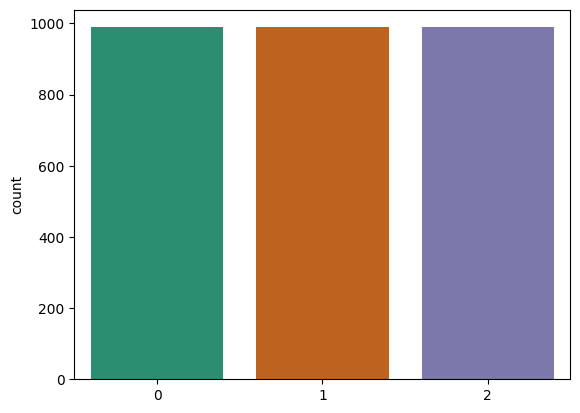

In [ ]:
sns.countplot(x=DNA_targets_oversampled.squeeze(),palette=colors)


# Show the plot
plt.show()

# Feature Selection

In [ ]:
selector = SelectKBest(f_classif, k=200)  # Select top 100 features
X_new = selector.fit_transform(DNA_features_oversampled, DNA_targets_oversampled)
X_new

array([[0.13889097, 0.14847545, 0.07414369, ..., 0.12499052, 0.09892093,
        0.09936072],
       [0.        , 0.0123424 , 0.        , ..., 0.03740455, 0.04933831,
        0.08672591],
       [0.        , 0.02510029, 0.02506849, ..., 0.03803414, 0.06271096,
        0.08818567],
       ...,
       [0.0177947 , 0.02413621, 0.02206768, ..., 0.00909908, 0.03196898,
        0.02275917],
       [0.        , 0.01202694, 0.00463945, ..., 0.03644854, 0.04807729,
        0.08450931],
       [0.22442637, 0.08633508, 0.12533633, ..., 0.10691781, 0.09772474,
        0.13834555]])

# Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, DNA_targets_oversampled, test_size=0.2, random_state=42,stratify=DNA_targets_oversampled)

In [ ]:
n_timesteps = 1


n_samples = X_train.shape[0]
n_features = X_train.shape[1] // n_timesteps


DNA_features_reshaped = X_train.reshape((n_samples, n_timesteps,n_features))

In [ ]:
len(DNA_features_reshaped[0][0])

200

In [ ]:
X_test_new = selector.fit_transform(X_test, y_test)
X_test_new.shape

(594, 200)

In [ ]:
n_timesteps = 1
n_samples = X_test_new.shape[0]
n_features = X_test_new.shape[1] // n_timesteps


X_test_reshape = X_test_new.reshape((n_samples,n_timesteps, n_features))

# Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization

model = Sequential()

# Adjust input shape to (timesteps, features) for Conv1D
model.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=( 1,200)))  # Adjusted input shape
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second convolutional layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Adding an LSTM layer
model.add(LSTM(64, return_sequences=True))  # This LSTM expects a 3D input
model.add(Dropout(0.3))

# Adding another LSTM layer
model.add(LSTM(16))
model.add(Dropout(0.3))

# Dense layers for output
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 128)         │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,603 (287.51 KB)

 Trainable params: 73,219 (286.01 KB)

 Non-trainable params: 384 (1.50 KB)

# Training

In [ ]:
history = model.fit(DNA_features_reshaped, y_train,
                        epochs=100,
                        validation_split=0.2,
                        verbose=1)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3829 - loss: 1.0909 - val_accuracy: 0.4716 - val_loss: 1.0942
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5897 - loss: 0.9914 - val_accuracy: 0.6126 - val_loss: 1.0329
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7127 - loss: 0.7748 - val_accuracy: 0.5516 - val_loss: 0.9598
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7757 - loss: 0.6382 - val_accuracy: 0.6274 - val_loss: 0.8564
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8002 - loss: 0.5658 - val_accuracy: 0.6884 - val_loss: 0.7965
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8142 - loss: 0.5492 - val_accuracy: 0.6505 - val_loss: 0.7559
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8248 - loss: 0.4822 - val_accuracy: 0.8105 - val_loss: 0.5463
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8339 - loss: 0.4504 - val_accuracy: 0.

# Evaluation

In [ ]:
predicted = model.predict(X_test_reshape)  # Get probabilities

# Convert probabilities to class labels
predicted_classes = np.argmax(predicted, axis=1)  # Get class labels

# Print classification report
print(classification_report(y_test, predicted_classes))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       198
           1       0.93      0.87      0.90       198
           2       0.97      0.90      0.93       198

    accuracy                           0.92       594
   macro avg       0.93      0.92      0.92       594
weighted avg       0.93      0.92      0.92       594



In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

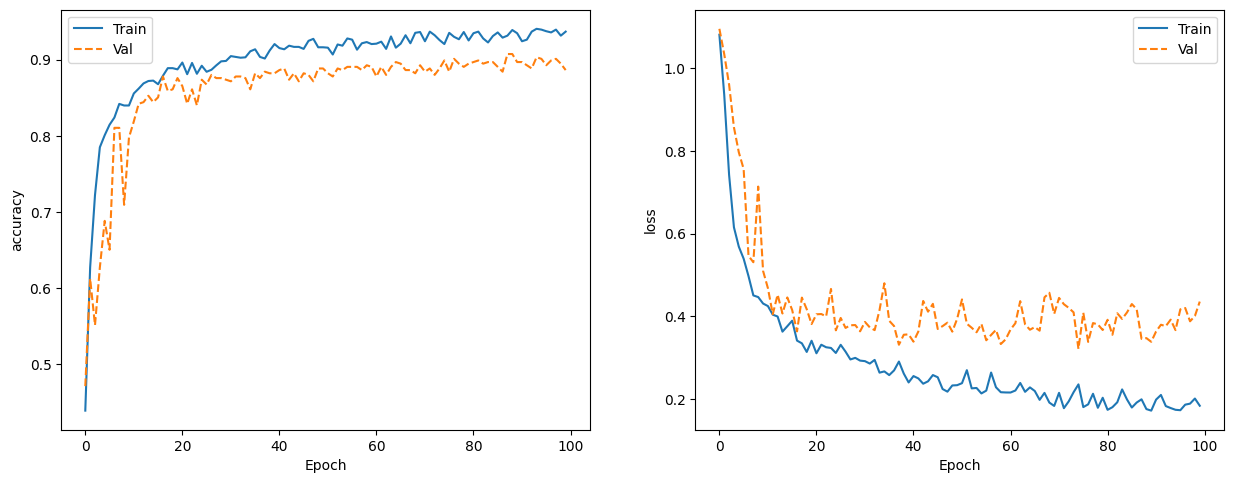

In [ ]:
plot_his(history)

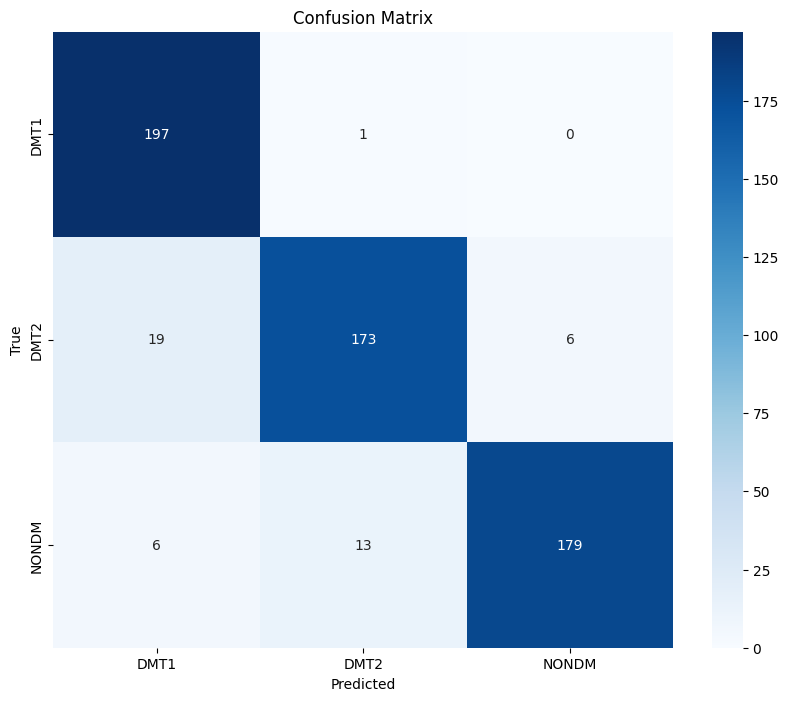

In [ ]:
class_labels = {
    'DMT1': 0,
    'DMT2': 1,
    'NONDM': 2
}
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()